# SpecParam

This notebook measures aperiodic activity using the 'spectral parameterization' algorithm.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_combined, sim_peak_oscillation
from neurodsp.spectral import compute_spectrum

from fooof import FOOOF
from fooof.plts import plot_spectrum, plot_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_35325/4032341483.py:9: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_sims, run_sims_load
from apm.methods import specparam
from apm.methods.settings import SPECPARAM_PARAMS, SPECPARAM_PARAMS_KNEE, FIT_F_RANGE, FIT_F_RANGE_LONG
from apm.plts.sims import plot_ap_sims, plot_pe_sims
from apm.plts.base import plot_lines
from apm.plts.settings import COLORS
from apm.sim.settings import (FS, EXP, EXPS, KNEES, FREQS, POWERS, BWS, N_SIMS,
                              SIM_PARAMS_AP, SIM_PARAMS_COMB, SIM_PARAMS_KNEE, SIM_PARAMS_PEAK)
from apm.sim.examples import SIG_AP, SIG_KN, SIG_OSC, SIG_COMB, SIG_PEAK
from apm.sim.sim import sim_combined_peak

## Settings

In [3]:
# Notebook settings
SAVE_FIG = False

In [4]:
# Plot settings
PSD_PLT_KWARGS = {
    'plt_log' : True,
}

In [5]:
# Settings for saving figures
SAVE_FIG = True
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '12_specparam'

In [6]:
# Settings for loading simulations
SIMPATH = APMDB().sims_path / 'time_series'

## Spectral Parameterization

In [7]:
# Check the SpecParam settings
SPECPARAM_PARAMS

{'fs': 500, 'f_range': (1, 50), 'min_peak_height': 0.05}

In [8]:
# Check the SpecParam settings - knee
SPECPARAM_PARAMS_KNEE

{'fs': 500,
 'f_range': (1, 75),
 'min_peak_height': 0.05,
 'aperiodic_mode': 'knee'}

### Spectral Parameterization on Example Signals

In [9]:
# Define a spectral model 
fm = FOOOF(min_peak_height=0.2, verbose=False)
fm_kn = FOOOF(min_peak_height=0.2, aperiodic_mode='knee', verbose=False)

#### Powerlaw Signal

In [10]:
# Compute the full power spectrum
freqs, powers = compute_spectrum(SIG_AP, FS, noverlap=0.5*FS, f_range=FIT_F_RANGE)

In [11]:
# Fit the spectral model
fm.fit(freqs, powers)

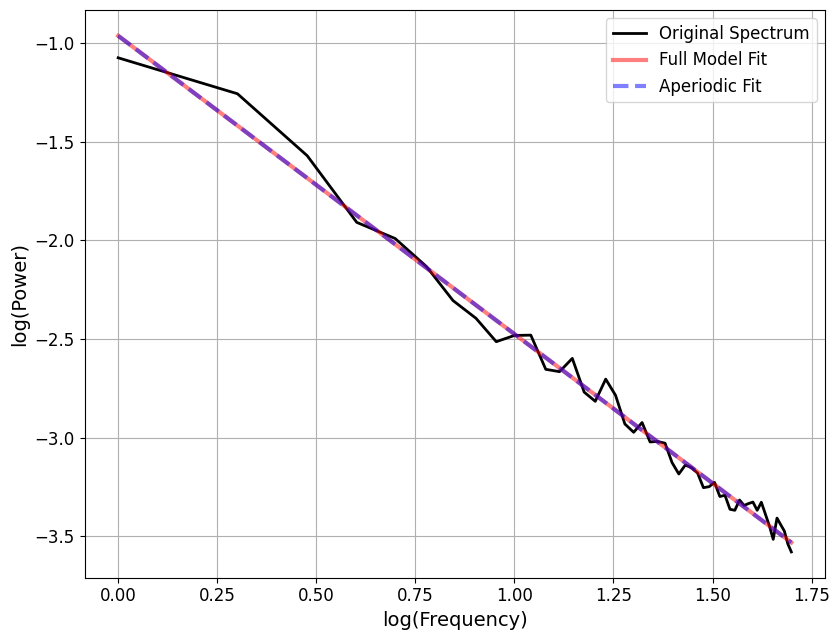

In [12]:
# Visualize 
fm.plot(**PSD_PLT_KWARGS,
        save_fig=SAVE_FIG, file_name='spec_example_ap' + EXT, file_path=FIGPATH)

In [13]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fm.get_params('aperiodic', 'exponent')))
print('Expected Exponent:\t {:1.4f}'.format(EXP))

Measured Exponent:	 1.5133
Expected Exponent:	 -1.5000


#### Combined Signal

In [14]:
# Compute the full power spectrum
freqs, powers = compute_spectrum(SIG_COMB, FS, noverlap=0.5*FS, f_range=FIT_F_RANGE)

In [15]:
# Fit the spectral model
fm.fit(freqs, powers)

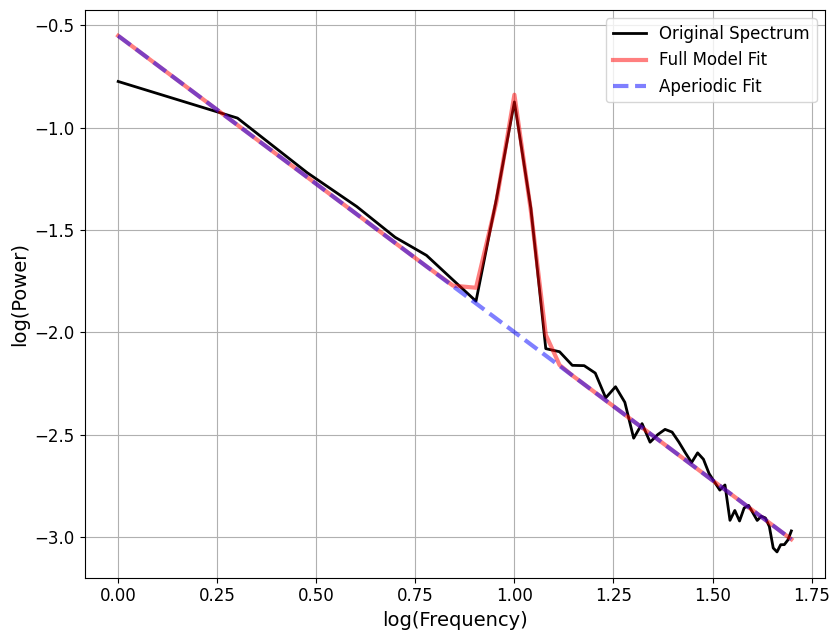

In [16]:
# Visualize 
fm.plot(**PSD_PLT_KWARGS,
        save_fig=SAVE_FIG, file_name='spec_example_pe' + EXT, file_path=FIGPATH)

In [17]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fm.get_params('aperiodic', 'exponent')))
print('Expected Exponent:\t {:1.4f}'.format(EXP))

Measured Exponent:	 1.4471
Expected Exponent:	 -1.5000


#### Knee Signal

In [18]:
# Compute the full power spectrum
freqs, powers = compute_spectrum(SIG_KN, FS, noverlap=0.5*FS, f_range=FIT_F_RANGE_LONG)

In [19]:
# Fit the spectral model
fm.fit(freqs, powers)
fm_kn.fit(freqs, powers)

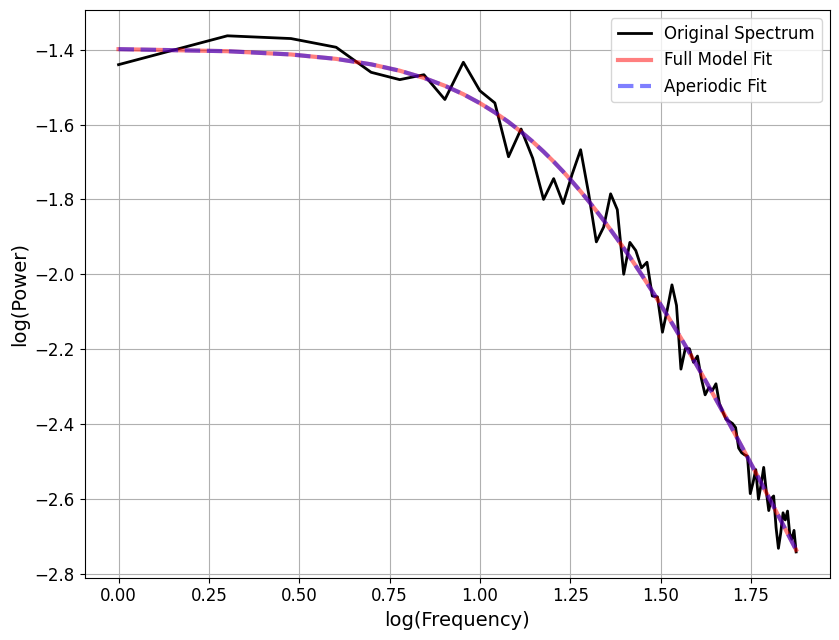

In [20]:
# Visualize 
fm_kn.plot(**PSD_PLT_KWARGS,
           save_fig=SAVE_FIG, file_name='spec_example_knee' + EXT, file_path=FIGPATH)

In [21]:
# Check the calculated value against ground truth
print('Measured Exponent (fixed):\t {:1.4f}'.format(fm.get_params('aperiodic', 'exponent')))
print('Measured Exponent (knee):\t {:1.4f}'.format(fm_kn.get_params('aperiodic', 'exponent')))
print('Expected Exponent:\t\t {:1.4f}'.format(2))

Measured Exponent (fixed):	 0.8266
Measured Exponent (knee):	 1.9631
Expected Exponent:		 2.0000


#### Peak Bandwidth

In [22]:
# Compute the full power spectrum
freqs, powers = compute_spectrum(SIG_PEAK, FS, noverlap=0.5*FS, f_range=FIT_F_RANGE_LONG)

In [23]:
# Fit the spectral model
fm.fit(freqs, powers)

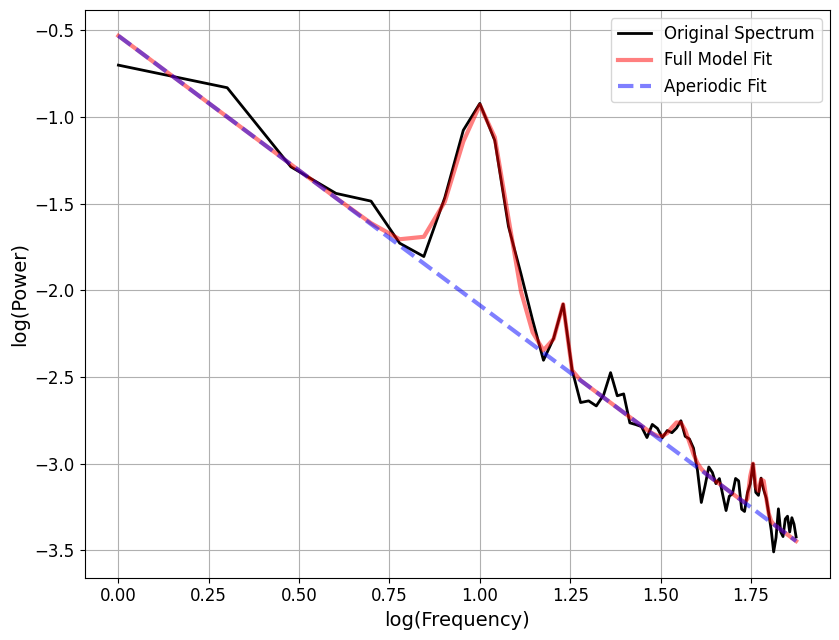

In [24]:
# Visualize 
fm.plot(**PSD_PLT_KWARGS,
        save_fig=SAVE_FIG, file_name='spec_example_bw' + EXT, file_path=FIGPATH)

In [25]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fm.get_params('aperiodic', 'exponent')))
print('Expected Exponent:\t {:1.4f}'.format(EXP))

Measured Exponent:	 1.5551
Expected Exponent:	 -1.5000


## SPECPARAM Simulation Tests

### Simulations: Aperiodic Variations

#### Aperiodic Exponent

In [26]:
# Run simulations calculating specparam estimation across exponents
sp_sims_exp, sp_sims_exp_var = run_sims(\
    sim_powerlaw, SIM_PARAMS_AP, specparam, SPECPARAM_PARAMS, 'update_exp', EXPS, N_SIMS)

#### Aperiodic Exponent (combined signal)

In [27]:
# Run simulations calculating specparam exponent across exponents, with an oscillation
sp_sims_comb, sp_sims_comb_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, specparam, SPECPARAM_PARAMS, 'update_comb_exp', EXPS, N_SIMS)

#### Visualize Results

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


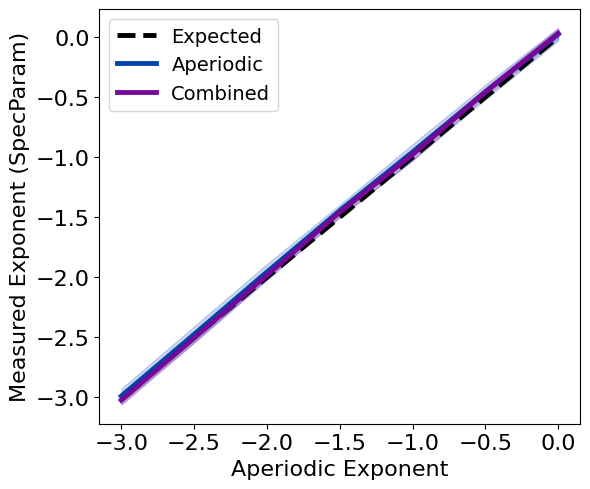

In [28]:
# Plot specparam exponent estimation across exponents, both with and without oscillation
plot_ap_sims(-1 * np.array(sp_sims_exp), sp_sims_exp_var,
             -1 * np.array(sp_sims_comb), sp_sims_comb_var, 
             'Measured Exponent (SpecParam)', expected=EXPS,
             save_fig=SAVE_FIG, file_name='sp_ap' + EXT, file_path=FIGPATH)

### Simulations: Periodic Variations

#### Oscillation Frequency

In [29]:
# Run simulations calculating specparam exponent across oscillation frequencies
sp_sims_freq, sp_sims_freq_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, specparam, SPECPARAM_PARAMS, 'update_freq', FREQS, N_SIMS)

#### Oscillation Power

In [30]:
# Run simulations calculating specparam exponent across oscillation power
sp_sims_pow, sp_sims_pow_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, specparam, SPECPARAM_PARAMS, 'update_pow', POWERS, N_SIMS)

#### Visualize Results

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


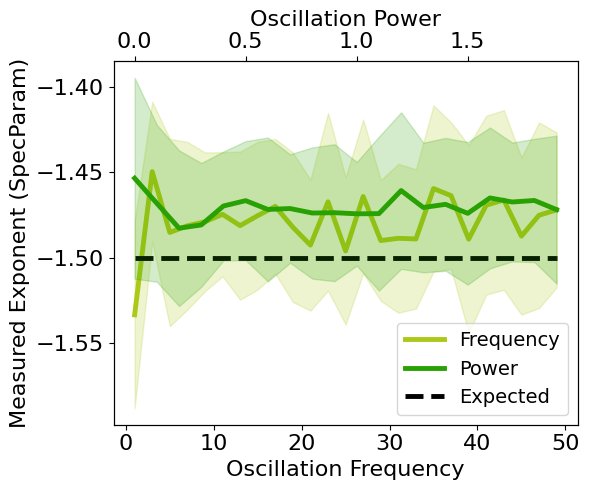

In [31]:
# Plot effect of oscillation variation on DFA exponent
plot_pe_sims(-1 * np.array(sp_sims_freq), sp_sims_freq_var,
             -1 * np.array(sp_sims_pow), sp_sims_pow_var,
             'Measured Exponent (SpecParam)', expected=[-1.5]*len(FREQS),
             save_fig=SAVE_FIG, file_name='sp_pe' + EXT, file_path=FIGPATH)

## Simulations: Knee Variations

In [32]:
# Run simulations calculating specparam exponent across different timescales
sp_sims_knee_lin, sp_sims_knee_lin_var = run_sims(\
    sim_synaptic_current, SIM_PARAMS_KNEE, specparam, SPECPARAM_PARAMS, 'update_knee', KNEES, N_SIMS)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encou

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/scipy/optimize/_lsq/trf

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


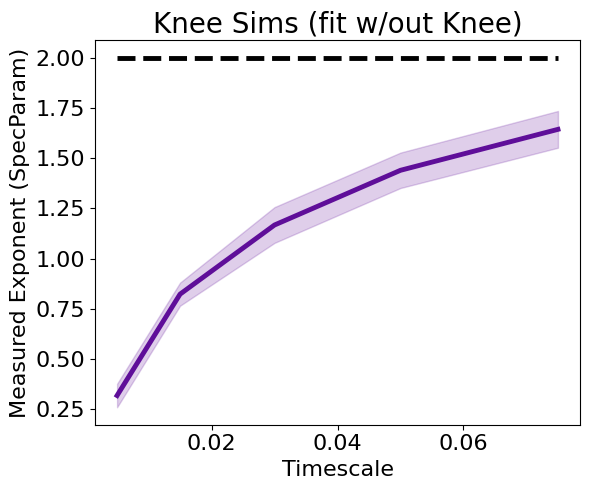

In [33]:
# Plot the estimated exponent across different timescales (estimated without a knee)
plot_lines(KNEES, sp_sims_knee_lin, sp_sims_knee_lin_var, color=COLORS['KN'], figsize=(6, 5))
plot_lines(KNEES, [2.0] * len(KNEES), color='black', linestyle='--', ax=plt.gca())
plot_lines(title='Knee Sims (fit w/out Knee)')
plot_lines(xlabel='Timescale', ylabel='Measured Exponent (SpecParam)')
plot_lines(save_fig=SAVE_FIG, file_name='sp_knee_lin' + EXT, file_path=FIGPATH)

In [34]:
# Run simulations calculating specparam exponent across different timescales
sp_sims_knee, sp_sims_knee_var = run_sims(\
    sim_synaptic_current, SIM_PARAMS_KNEE, specparam, SPECPARAM_PARAMS_KNEE, 'update_knee', KNEES, N_SIMS)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


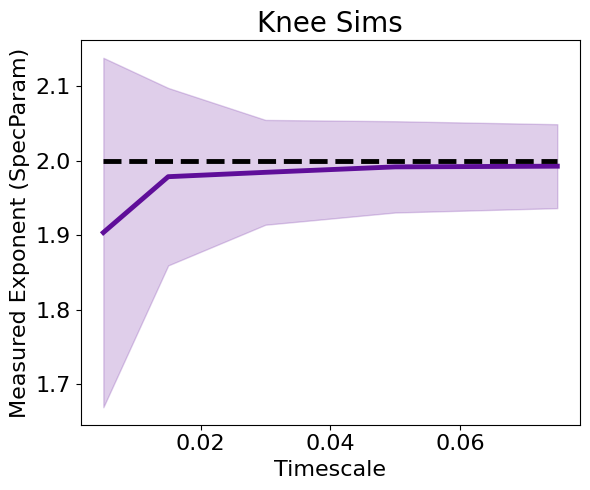

In [35]:
# Plot the estimated exponent across different timescales (estimated with a knee)
plot_lines(KNEES, sp_sims_knee, sp_sims_knee_var, color=COLORS['KN'], figsize=(6, 5))
plot_lines(KNEES, [2.0] * len(KNEES), color='black', linestyle='--', ax=plt.gca())
plot_lines(title='Knee Sims')
plot_lines(xlabel='Timescale', ylabel='Measured Exponent (SpecParam)')
plot_lines(save_fig=SAVE_FIG, file_name='sp_knee' + EXT, file_path=FIGPATH)

## Simulations: Bandwidth Variations

In [36]:
# Simulating 
# sp_sims_bw, sp_sims_bw_var = run_sims(\
#     sim_combined_peak, SIM_PARAMS_PEAK, specparam, SPECPARAM_PARAMS, 'update_peak_bw', BWS, N_SIMS)

In [37]:
# Run simulations calculating specparam exponent estimate across peak bandwidth (sims from file)
sp_sims_bw, sp_sims_bw_var = run_sims_load(\
    SIMPATH / 'ts_sims_comb_bw', specparam, SPECPARAM_PARAMS)

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


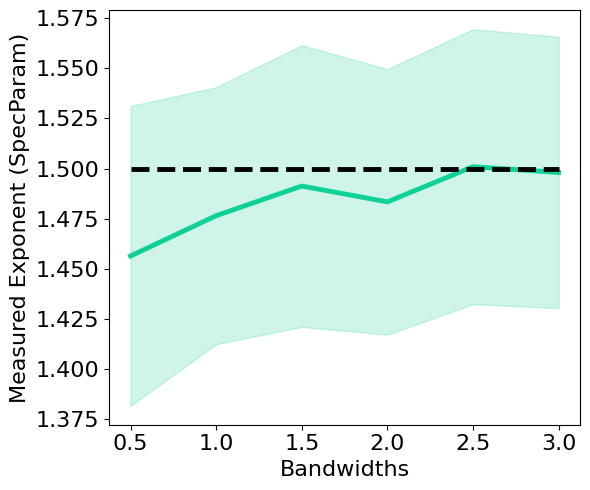

In [38]:
# Plot the estimated exponent across different timescales (estimated with a knee)
plot_lines(BWS, sp_sims_bw, sp_sims_bw_var, color=COLORS['BW'], figsize=(6, 5))
plot_lines(BWS, [-EXP] * len(BWS), color='black', linestyle='--', ax=plt.gca())
#plot_lines(title='Bandwidth Sims')
plot_lines(xlabel='Bandwidths', ylabel='Measured Exponent (SpecParam)')
plot_lines(save_fig=SAVE_FIG, file_name='sp_bw' + EXT, file_path=FIGPATH)

## Conclusions

Overall, we can see the following patterns in these simulations:
- Words, words, words.